# Deteksi Penipuan (Fraud) Kartu Kredit  
**Model:** Logistic Regression (baseline) vs XGBoost (advanced)  
**Dataset:** `creditcard.csv` (Kaggle Credit Card Fraud Detection)

Notebook ini mengikuti arahan **Modul 15**: pipeline end-to-end, komparasi minimal 2 algoritma, evaluasi untuk data imbalanced (bukan hanya akurasi), menampilkan *Confusion Matrix* + *ROC Curve* + *Feature Importance*, dan menyimpan model terbaik untuk deployment (Streamlit).


> **Catatan:** Pastikan file `creditcard.csv` berada di folder yang sama dengan notebook ini (atau ubah `DATA_PATH`).  
> Jika `xgboost` belum terpasang, jalankan instalasi di bawah (opsional).


In [1]:
# Jika menjalankan di environment yang belum punya xgboost, jalankan cell ini:
# !pip -q install xgboost


## 0) Setup & Import Library

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import display

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report,
    roc_auc_score, roc_curve,
    precision_score, recall_score, f1_score,
    average_precision_score, precision_recall_curve
)

import joblib
import warnings
warnings.filterwarnings("ignore")

# XGBoost
try:
    from xgboost import XGBClassifier
except Exception as e:
    XGBClassifier = None
    print("XGBoost belum tersedia. Install dulu: pip install xgboost")
    print("Error:", e)

RANDOM_STATE = 42


## 1) Load Dataset

In [3]:
DATA_PATH = "creditcard.csv"  # pastikan file ada di folder kerja
df = pd.read_csv(DATA_PATH)

print("Shape:", df.shape)
display(df.head())


Shape: (20000, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## 2) Data Quality Check & Cek Imbalance Label

In [4]:
missing = df.isna().sum().sort_values(ascending=False)
dupes = df.duplicated().sum()

print("Total missing values:", int(missing.sum()))
print("Total duplicated rows:", int(dupes))
display(missing.head(10))

target_col = "Class"  # fraud=1, non-fraud=0
class_counts = df[target_col].value_counts().sort_index()
class_ratio = (class_counts / class_counts.sum() * 100).round(6)

print("\nClass counts (0=non-fraud, 1=fraud):")
display(class_counts)

print("\nClass ratio (%):")
display(class_ratio)


Total missing values: 0
Total duplicated rows: 69


Time      0
V16       0
Amount    0
V28       0
V27       0
V26       0
V25       0
V24       0
V23       0
V22       0
dtype: int64


Class counts (0=non-fraud, 1=fraud):


Class
0    19915
1       85
Name: count, dtype: int64


Class ratio (%):


Class
0    99.575
1     0.425
Name: count, dtype: float64

### Plot Distribusi Kelas (Non-fraud vs Fraud)

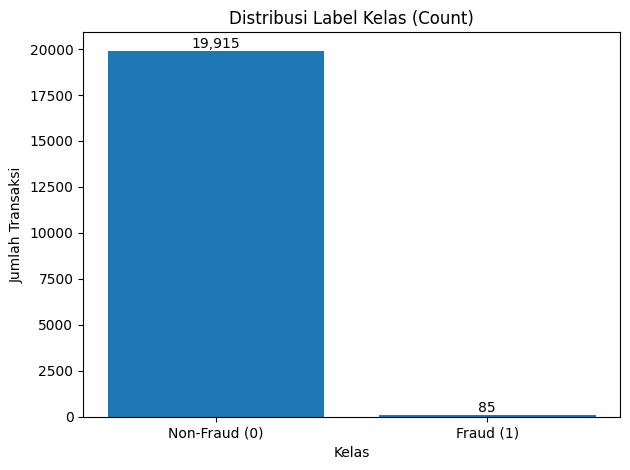

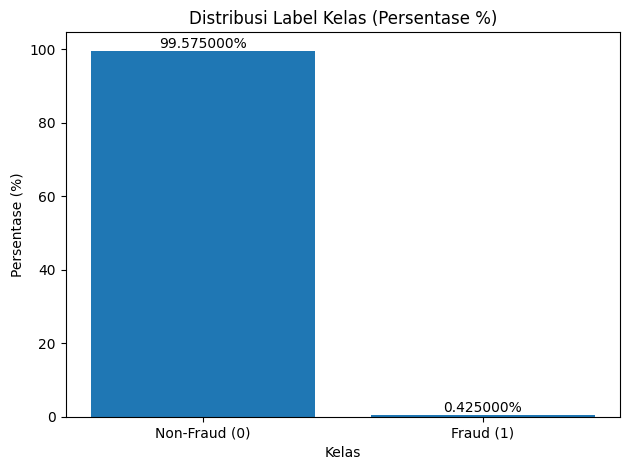

Imbalance ratio (Non-Fraud : Fraud) = 234.29 : 1


In [5]:
labels = ["Non-Fraud (0)", "Fraud (1)"]
counts = class_counts.values
ratios = class_ratio.values

# 1) Bar chart: jumlah data per kelas
plt.figure()
bars = plt.bar(labels, counts)
plt.title("Distribusi Label Kelas (Count)")
plt.xlabel("Kelas")
plt.ylabel("Jumlah Transaksi")

for bar, val in zip(bars, counts):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f"{val:,}",
        ha="center",
        va="bottom"
    )

plt.tight_layout()
plt.show()

# 2) Bar chart: persentase data per kelas
plt.figure()
bars2 = plt.bar(labels, ratios)
plt.title("Distribusi Label Kelas (Persentase %)")
plt.xlabel("Kelas")
plt.ylabel("Persentase (%)")

for bar, val in zip(bars2, ratios):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f"{val:.6f}%",
        ha="center",
        va="bottom"
    )

plt.tight_layout()
plt.show()

# 3) Ringkasan imbalance ratio
if counts[1] > 0:
    imbalance_ratio = counts[0] / counts[1]
    print(f"Imbalance ratio (Non-Fraud : Fraud) = {imbalance_ratio:.2f} : 1")
else:
    print("Tidak ada sampel Fraud (Class=1) di dataset ini.")


## 3) EDA Singkat (Distribusi Fitur Utama)

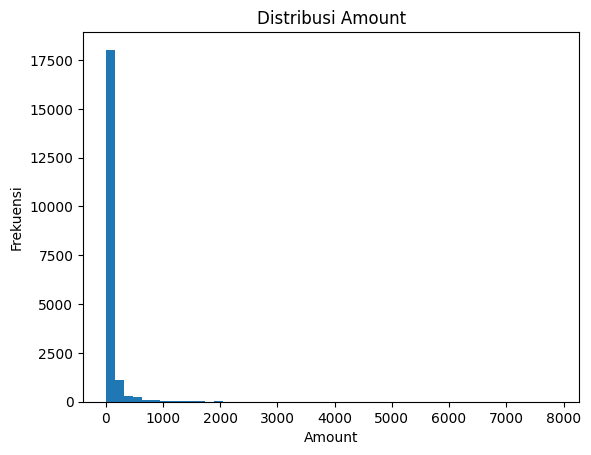

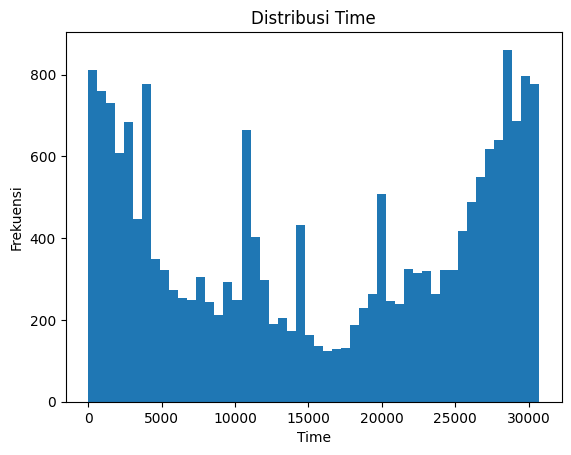

In [6]:
plt.figure()
plt.hist(df["Amount"], bins=50)
plt.title("Distribusi Amount")
plt.xlabel("Amount")
plt.ylabel("Frekuensi")
plt.show()

plt.figure()
plt.hist(df["Time"], bins=50)
plt.title("Distribusi Time")
plt.xlabel("Time")
plt.ylabel("Frekuensi")
plt.show()


## 4) Split Feature/Target

In [7]:
X = df.drop(columns=[target_col])
y = df[target_col].astype(int)

print("X shape:", X.shape)
print("y positive rate (fraud=1):", float(y.mean()))


X shape: (20000, 30)
y positive rate (fraud=1): 0.00425


## 5) Preprocessing (Scaling untuk kolom tertentu)

- Dataset ini berisi fitur `V1..V28` (hasil PCA) + `Time` + `Amount`.
- Umumnya `Amount` (dan opsional `Time`) perlu scaling; fitur PCA sudah relatif terstandardisasi.
- Karena **Logistic Regression** sensitif terhadap skala, scaling dibutuhkan. Untuk **XGBoost**, scaling tidak wajib, tetapi kita tetap pakai preprocessing yang konsisten lewat pipeline.

> Jika ingin, kamu bisa scaling `Time` juga (misalnya `scale_cols = ["Amount", "Time"]`).


In [8]:
# Pilih kolom yang akan di-scaling.
scale_cols = ["Amount"]
passthrough_cols = [c for c in X.columns if c not in scale_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("scale", RobustScaler(), scale_cols),
        ("pass", "passthrough", passthrough_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)


## 6) Train-Test Split (Stratified)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

print("Train size:", X_train.shape, "Test size:", X_test.shape)
print("Train fraud rate:", float(y_train.mean()), "Test fraud rate:", float(y_test.mean()))


Train size: (16000, 30) Test size: (4000, 30)
Train fraud rate: 0.00425 Test fraud rate: 0.00425


## 7) Helper Function Evaluasi (Imbalanced Metrics)

Metrik dihitung dengan fokus pada kelas positif **fraud=1**: Precision, Recall, F1, ROC-AUC, dan PR-AUC.
Notebook juga menampilkan:
- Confusion Matrix
- ROC Curve
- Precision-Recall Curve (nilai plus untuk data imbalanced)


In [10]:
def evaluate_binary_classifier(name, y_true, y_pred, y_proba):
    """
    Evaluasi untuk data imbalanced.
    Semua metrik dihitung untuk kelas positif = fraud (1).
    """
    prec = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
    rec = recall_score(y_true, y_pred, pos_label=1, zero_division=0)
    f1 = f1_score(y_true, y_pred, pos_label=1, zero_division=0)
    roc_auc = roc_auc_score(y_true, y_proba)
    pr_auc = average_precision_score(y_true, y_proba)

    print(f"\n{name}")
    print(f"Precision (fraud=1): {prec:.6f}")
    print(f"Recall    (fraud=1): {rec:.6f}")
    print(f"F1-score  (fraud=1): {f1:.6f}")
    print(f"ROC-AUC           : {roc_auc:.6f}")
    print(f"PR-AUC (AvgPrec)  : {pr_auc:.6f}")

    print("\nClassification report:")
    print(classification_report(y_true, y_pred, digits=6))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.4f})")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.title(f"ROC Curve - {name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

    # Precision-Recall Curve
    p, r, _ = precision_recall_curve(y_true, y_proba)
    plt.figure()
    plt.plot(r, p, label=f"{name} (PR-AUC={pr_auc:.4f})")
    plt.title(f"Precision-Recall Curve - {name}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    plt.show()

    return {
        "Model": name,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "ROC_AUC": roc_auc,
        "PR_AUC": pr_auc,
        "fpr": fpr,
        "tpr": tpr
    }


## 8) Model 1 — Logistic Regression (Baseline)

- Menggunakan `class_weight='balanced'` untuk membantu mengatasi imbalance.
- Pipeline: preprocessing → model.



Logistic Regression
Precision (fraud=1): 0.223684
Recall    (fraud=1): 1.000000
F1-score  (fraud=1): 0.365591
ROC-AUC           : 0.998213
PR-AUC (AvgPrec)  : 0.563554

Classification report:
              precision    recall  f1-score   support

           0   1.000000  0.985187  0.992538      3983
           1   0.223684  1.000000  0.365591        17

    accuracy                       0.985250      4000
   macro avg   0.611842  0.992594  0.679065      4000
weighted avg   0.996701  0.985250  0.989874      4000



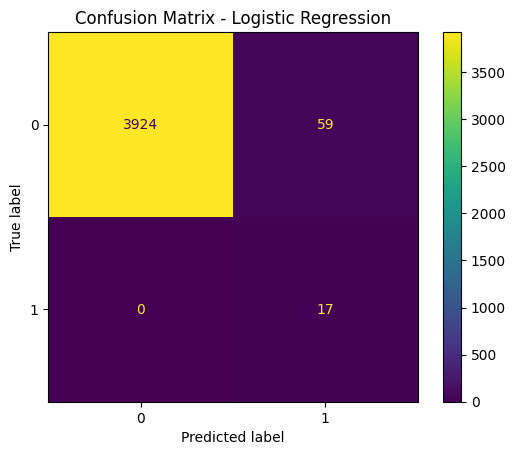

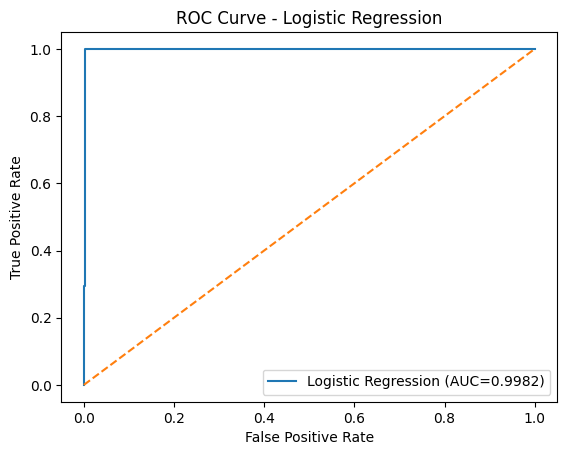

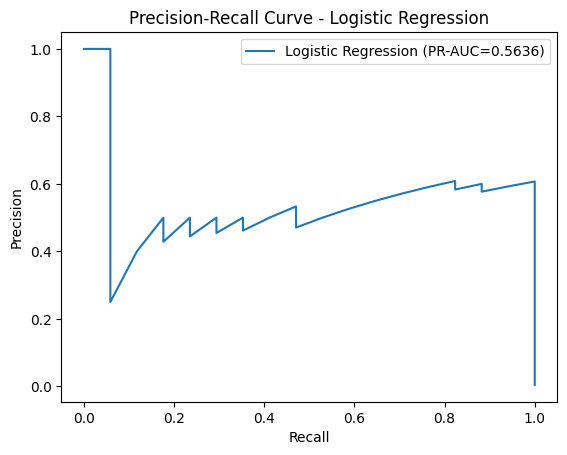

In [11]:
lr_clf = LogisticRegression(
    max_iter=3000,
    class_weight="balanced",
    n_jobs=None,
    random_state=RANDOM_STATE
)

lr_pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("model", lr_clf)
])

lr_pipe.fit(X_train, y_train)

lr_pred = lr_pipe.predict(X_test)
lr_proba = lr_pipe.predict_proba(X_test)[:, 1]

lr_metrics = evaluate_binary_classifier("Logistic Regression", y_test, lr_pred, lr_proba)


## 9) Model 2 — XGBoost (Advanced)

- Menggunakan `scale_pos_weight = (#neg/#pos)` untuk imbalance.
- Pipeline: preprocessing → model.



XGBoost
Precision (fraud=1): 0.941176
Recall    (fraud=1): 0.941176
F1-score  (fraud=1): 0.941176
ROC-AUC           : 0.999970
PR-AUC (AvgPrec)  : 0.993808

Classification report:
              precision    recall  f1-score   support

           0   0.999749  0.999749  0.999749      3983
           1   0.941176  0.941176  0.941176        17

    accuracy                       0.999500      4000
   macro avg   0.970463  0.970463  0.970463      4000
weighted avg   0.999500  0.999500  0.999500      4000



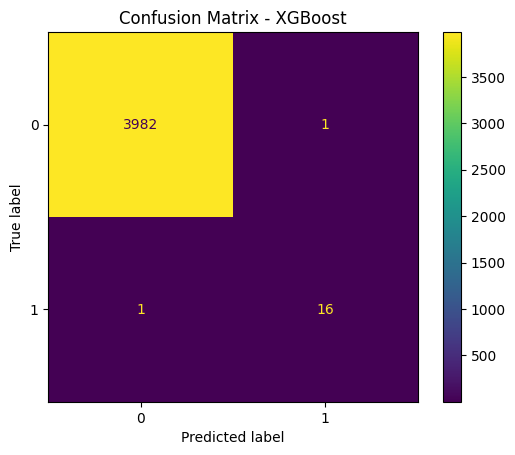

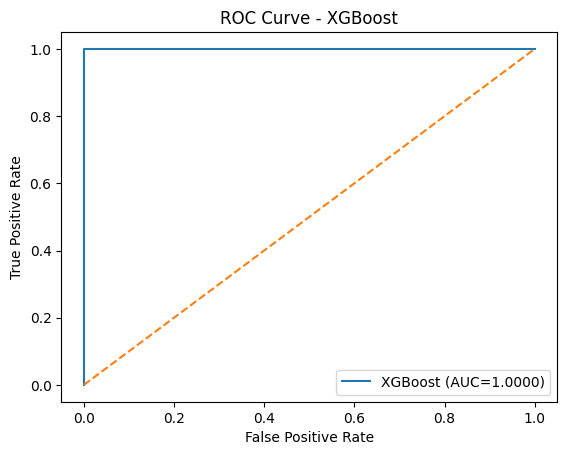

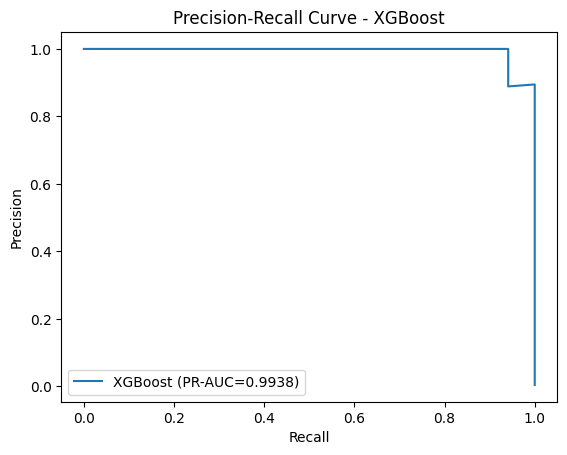

In [12]:
if XGBClassifier is None:
    raise RuntimeError("XGBoost tidak tersedia. Install dulu: pip install xgboost")

neg = int((y_train == 0).sum())
pos = int((y_train == 1).sum())
scale_pos_weight = neg / max(pos, 1)

xgb_clf = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    eval_metric="logloss",
    scale_pos_weight=scale_pos_weight
)

xgb_pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("model", xgb_clf)
])

xgb_pipe.fit(X_train, y_train)

xgb_pred = xgb_pipe.predict(X_test)
xgb_proba = xgb_pipe.predict_proba(X_test)[:, 1]

xgb_metrics = evaluate_binary_classifier("XGBoost", y_test, xgb_pred, xgb_proba)


## 10) Perbandingan Model (Tabel Ringkas + ROC Gabungan)

,Model,Precision,Recall,F1,ROC_AUC,PR_AUC
1,XGBoost,0.941176,0.941176,0.941176,0.999970,0.993808
0,Logistic Regression,0.223684,1.000000,0.365591,0.998213,0.563554


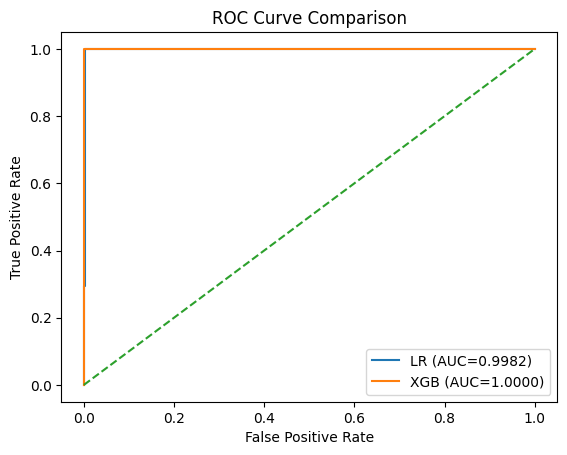

In [13]:
results = pd.DataFrame([
    {k: v for k, v in lr_metrics.items() if k not in ["fpr", "tpr"]},
    {k: v for k, v in xgb_metrics.items() if k not in ["fpr", "tpr"]},
]).sort_values(by="F1", ascending=False)

display(results)

# ROC gabungan
plt.figure()
plt.plot(lr_metrics["fpr"], lr_metrics["tpr"], label=f"LR (AUC={lr_metrics['ROC_AUC']:.4f})")
plt.plot(xgb_metrics["fpr"], xgb_metrics["tpr"], label=f"XGB (AUC={xgb_metrics['ROC_AUC']:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


## 11) Threshold Tuning (Opsional)

Untuk data imbalanced, threshold default 0.5 tidak selalu optimal.  
Di sini kita cari threshold terbaik berdasarkan **F1** pada data test *untuk analisis*.

> **Catatan akademik:** Idealnya threshold dituning di validation set, lalu evaluasi final di test set.


Best threshold by F1 (fraud=1):
LR  threshold=0.98, F1=0.739130
XGB threshold=0.75, F1=0.969697


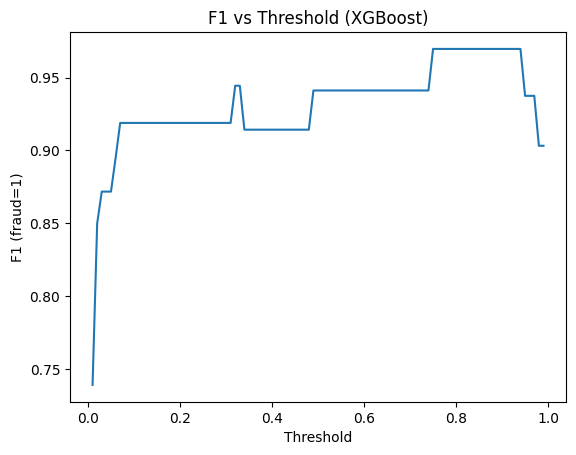

In [14]:
def best_threshold_by_f1(y_true, y_proba, thresholds=np.linspace(0.01, 0.99, 99)):
    best_t, best_f1 = 0.5, -1
    for t in thresholds:
        y_hat = (y_proba >= t).astype(int)
        score = f1_score(y_true, y_hat, pos_label=1, zero_division=0)
        if score > best_f1:
            best_f1 = score
            best_t = t
    return best_t, best_f1

lr_best_t, lr_best_f1 = best_threshold_by_f1(y_test, lr_proba)
xgb_best_t, xgb_best_f1 = best_threshold_by_f1(y_test, xgb_proba)

print("Best threshold by F1 (fraud=1):")
print(f"LR  threshold={lr_best_t:.2f}, F1={lr_best_f1:.6f}")
print(f"XGB threshold={xgb_best_t:.2f}, F1={xgb_best_f1:.6f}")

thresholds = np.linspace(0.01, 0.99, 99)
xgb_f1s = [f1_score(y_test, (xgb_proba >= t).astype(int), pos_label=1, zero_division=0) for t in thresholds]

plt.figure()
plt.plot(thresholds, xgb_f1s)
plt.title("F1 vs Threshold (XGBoost)")
plt.xlabel("Threshold")
plt.ylabel("F1 (fraud=1)")
plt.show()


## 12) Pilih Model Terbaik (untuk deployment)

In [15]:
# Model terbaik dipilih berdasarkan F1 pada threshold default 0.5 (sesuai tabel perbandingan).
best_name = results.iloc[0]["Model"]
best_model = lr_pipe if best_name == "Logistic Regression" else xgb_pipe

# Simpan threshold terbaik (hasil tuning) untuk dipakai di Streamlit (opsional)
best_threshold = lr_best_t if best_name == "Logistic Regression" else xgb_best_t

print("Best model (by F1 @threshold=0.5):", best_name)
print("Best threshold (by F1, analysis):", best_threshold)


Best model (by F1 @threshold=0.5): XGBoost
Best threshold (by F1, analysis): 0.75


## 13) Interpretasi Model (Wajib untuk pembahasan)

- **XGBoost:** feature importance (Top-k)
- **Logistic Regression:** koefisien (|coef| terbesar)

Ini membantu bagian *Hasil & Pembahasan* di laporan.


,feature,importance
15,V14,0.509192
5,V4,0.192151
4,V3,0.049331
20,V19,0.033983
2,V1,0.029599
13,V12,0.025042
19,V18,0.020540
17,V16,0.016150
18,V17,0.015582
11,V10,0.015323


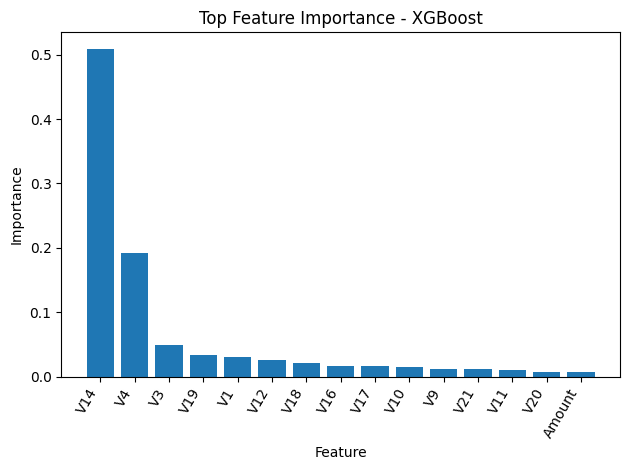

,feature,coef,abs_coef
5,V4,2.608598,2.608598
28,V27,-1.995797,1.995797
26,V25,-1.749544,1.749544
11,V10,-1.684424,1.684424
20,V19,-1.315281,1.315281
6,V5,-1.163403,1.163403
3,V2,-1.161793,1.161793
25,V24,-1.134764,1.134764
8,V7,1.123629,1.123629
22,V21,1.024813,1.024813


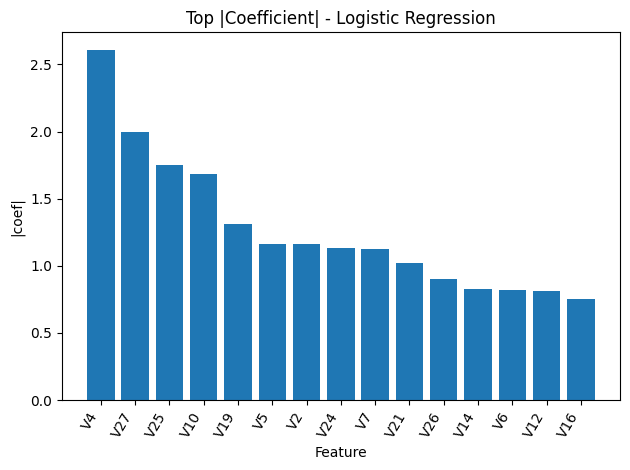

In [16]:
# Feature names untuk masing-masing pipeline (lebih rapi & aman)
feature_names_xgb = xgb_pipe.named_steps["prep"].get_feature_names_out()
feature_names_lr = lr_pipe.named_steps["prep"].get_feature_names_out()

topk = 15

# --- Feature importance XGBoost ---
booster = xgb_pipe.named_steps["model"]
importances = booster.feature_importances_

fi = pd.DataFrame({"feature": feature_names_xgb, "importance": importances}).sort_values("importance", ascending=False)
display(fi.head(topk))

plt.figure()
plt.bar(fi["feature"].head(topk), fi["importance"].head(topk))
plt.title("Top Feature Importance - XGBoost")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.xticks(rotation=60, ha="right")
plt.tight_layout()
plt.show()

# --- Koefisien Logistic Regression ---
lr_model = lr_pipe.named_steps["model"]
coefs = lr_model.coef_.ravel()

coef_df = pd.DataFrame({"feature": feature_names_lr, "coef": coefs})
coef_df["abs_coef"] = coef_df["coef"].abs()
coef_df = coef_df.sort_values("abs_coef", ascending=False)

display(coef_df.head(topk))

plt.figure()
plt.bar(coef_df["feature"].head(topk), coef_df["abs_coef"].head(topk))
plt.title("Top |Coefficient| - Logistic Regression")
plt.xlabel("Feature")
plt.ylabel("|coef|")
plt.xticks(rotation=60, ha="right")
plt.tight_layout()
plt.show()


## 14) Simpan Model Terbaik (Wajib)

In [17]:
MODEL_OUT = "best_fraud_model.joblib"
joblib.dump(best_model, MODEL_OUT)

print("Saved model to:", MODEL_OUT)

# Simpan threshold (berguna untuk Streamlit)
THRESH_OUT = "best_threshold.txt"
with open(THRESH_OUT, "w") as f:
    f.write(str(best_threshold))

print("Saved best threshold to:", THRESH_OUT, "=", best_threshold)


Saved model to: best_fraud_model.joblib
Saved best threshold to: best_threshold.txt = 0.75


## 15) Contoh Prediksi 1 Baris (Simulasi Input Streamlit)

In [18]:
sample = X_test.iloc[[0]].copy()
pred_proba = best_model.predict_proba(sample)[0, 1]
pred_class_default = int(pred_proba >= 0.5)
pred_class_best_t = int(pred_proba >= best_threshold)

print("Sample prediction:")
print("Predicted probability (fraud=1):", float(pred_proba))
print("Predicted class @0.5 threshold :", pred_class_default)
print("Predicted class @best threshold:", pred_class_best_t)


Sample prediction:
Predicted probability (fraud=1): 1.2194849659863394e-05
Predicted class @0.5 threshold : 0
Predicted class @best threshold: 0


## 16) (Opsional) Cross-Validation Singkat (Stratified) — ROC-AUC

In [19]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

lr_auc_cv = cross_val_score(lr_pipe, X, y, scoring="roc_auc", cv=cv, n_jobs=-1)
xgb_auc_cv = cross_val_score(xgb_pipe, X, y, scoring="roc_auc", cv=cv, n_jobs=-1)

print("Cross-validation ROC-AUC:")
print("LR  mean:", lr_auc_cv.mean(), "std:", lr_auc_cv.std())
print("XGB mean:", xgb_auc_cv.mean(), "std:", xgb_auc_cv.std())


Cross-validation ROC-AUC:
LR  mean: 0.9659671249870774 std: 0.025959776044879108
XGB mean: 0.9966061644341393 std: 0.005958635828268807
